'*Best way to live in California is to be from somewhere else*'.

~Cormac McCarthy

# California housing prices - dataset regression

## Introduction

California housing prices appears in many places all over the internet. The original dataset was published by University of Porto (https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html) and re-published on Kaggle.

The dataset contains 20640 house prices from 1990.

## Kernel setup

In [1]:
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import sys

sys.path.append('../')
sns.set(rc={'figure.figsize': (11.7, 8.27)})

## Dataset


In [2]:
from california_housing_prices.load_data import load_data

train_set = load_data('./dataset/', 'housing.csv', keep_na=True)
train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


The number of features is quite limited, in addition some of the columns might be ruled-out as might not provide any improvement in the dataset classification.

| Name               | Description                                                                                         |
|--------------------|-----------------------------------------------------------------------------------------------------|
| longitude          | A measure of how far west a house is; a higher value is farther west                                |
| latitude           | A measure of how far north a house is; a higher value is farther north                              |
| housing_median_age | Median age of a house within a block; a lower number is a newer building                            |
| total_rooms        | Total number of rooms within a block                                                                |
| total_bedrooms     | Total number of bedrooms within a block                                                             |
| population         | Total number of people residing within a block                                                      |
| households         | Total number of households, a group of people residing within a home unit, for a block              |
| median_income      | Median income for households within a block of houses (measured in tens of thousands of US Dollars) |
| median_house_value | Median house value for households within a block (measured in US Dollars)                           |
| ocean_proximity    | Location of the house w.r.t ocean/sea                                                               |

## Insight

In [3]:
train_set.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


The cheapest median house value was 14,9600 USD whereas the most expensive block was 500,001.00 USD. On average, typical housing block has 2635 bedrooms and a population of 1425 which means that the average Californian had ~1.85 room for himself. On average, the same Californian had income equal to 38,700 USD per year and lived in a housing block where average median house value was equal to 206,855.00 USD.

### Ocean proximity

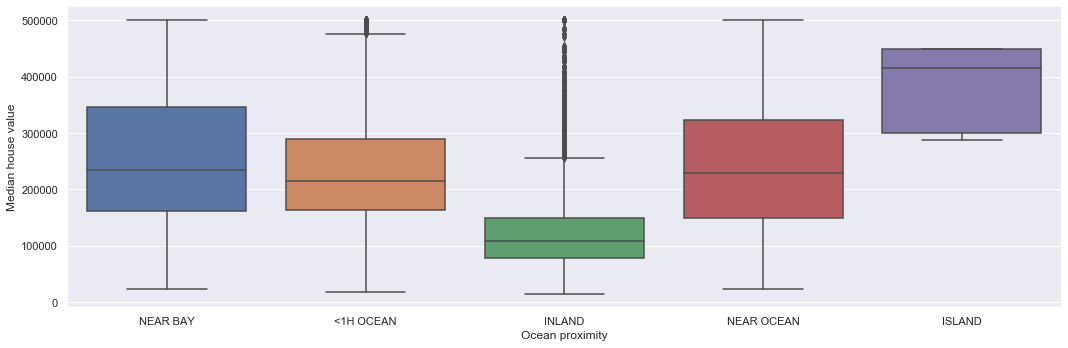

In [4]:
sns.catplot('ocean_proximity', 'median_house_value', data=train_set, aspect=3, kind='box')
plt.xlabel('Ocean proximity')
plt.ylabel('Median house value');

The categorical plot provides very useful and clean information that the average house value is positively correlated with distance from the ocean. It is clear that houses located on the island are generally worth more than in the rest. The cheapest houses are located inland whereas houses located near bay, near ocean or < 1h from ocean are on average worth similar amounts.

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64


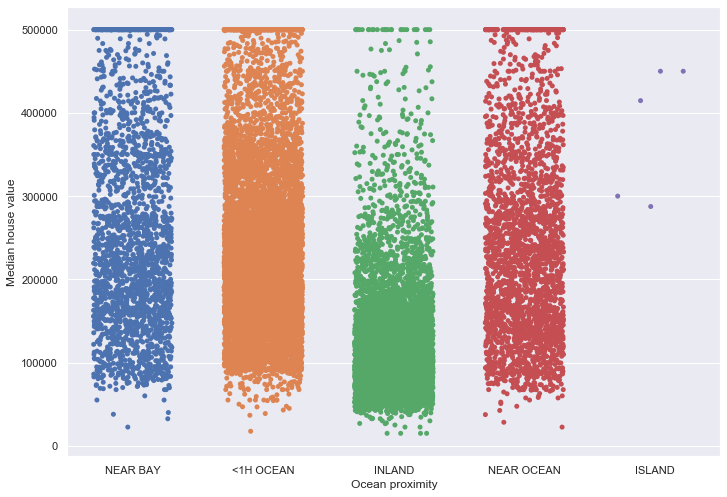

In [5]:
ocean_value = sns.stripplot(train_set['ocean_proximity'], train_set['median_house_value'], jitter=0.3)
ocean_value.set(xlabel='Ocean proximity', ylabel='Median house value')
print(train_set['ocean_proximity'].value_counts());

Although the housing blocks located on island appeared to be most expensive ones, it might not contain enough training examples to confirm it. Only 5 housing blocks are present with category *ISLAND*.

To avoid overfitting, it might be good idea to remove rows with *ISLAND* values.

### Median house value

Skewness: 0.9777632739098341


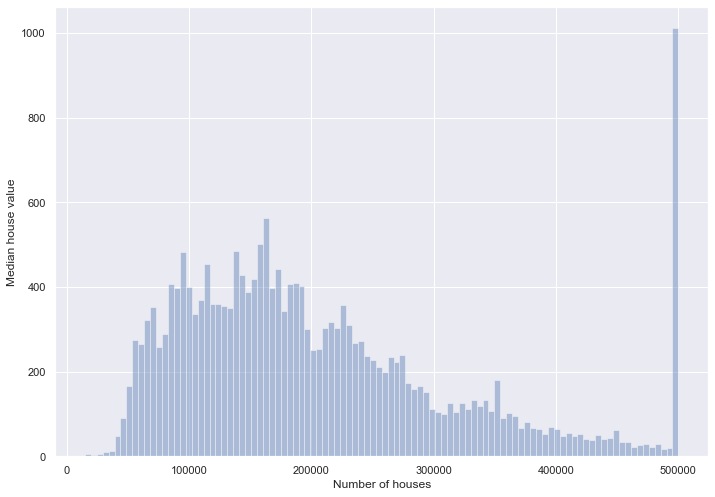

In [6]:
distplot_house_value = sns.distplot(train_set['median_house_value'], kde=False, bins=100)
distplot_house_value.set(xlabel='Number of houses', ylabel='Median house value')
print(f"Skewness: {train_set['median_house_value'].skew()}")

The histogram provides two important information about the dataset.

Firstly, there are outliers that will affect predictions - there is a group of houses that costs over 500,000.00 USD.

Secondly, the histogram is skewed towards the left side.

Skewness: 0.09990587507569614


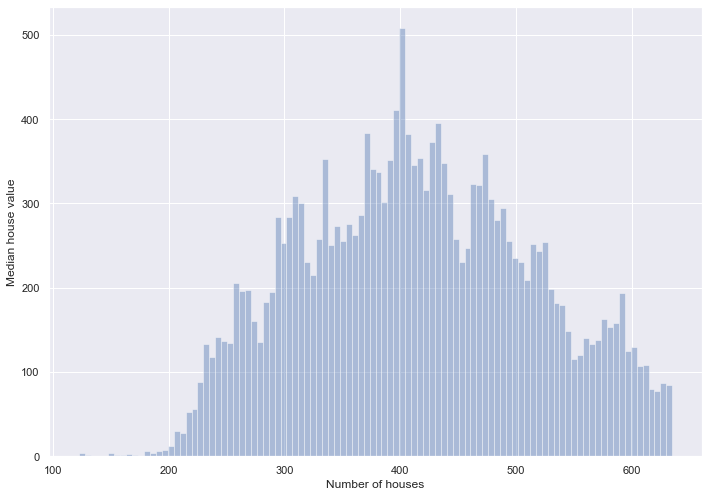

In [7]:
from scipy import stats


z = np.abs(stats.zscore(train_set['median_house_value']))
train_set_no_outliers = train_set.drop(*np.where(z > 1.7))
median_house_value_transformed = np.sqrt(train_set_no_outliers['median_house_value'])
distplot_house_value_transformed = sns.distplot(median_house_value_transformed, kde=False, bins=100)
distplot_house_value_transformed.set(xlabel='Number of houses', ylabel='Median house value')
print(f"Skewness: {median_house_value_transformed.skew()}")

Removing the outliers with Z value greater than 1.7 and applying root square function, reduces skewness around 10 times.

Median house values look much more like a normal distribution which will benefit further analysis & predictions.

### Number of tenants vs house value

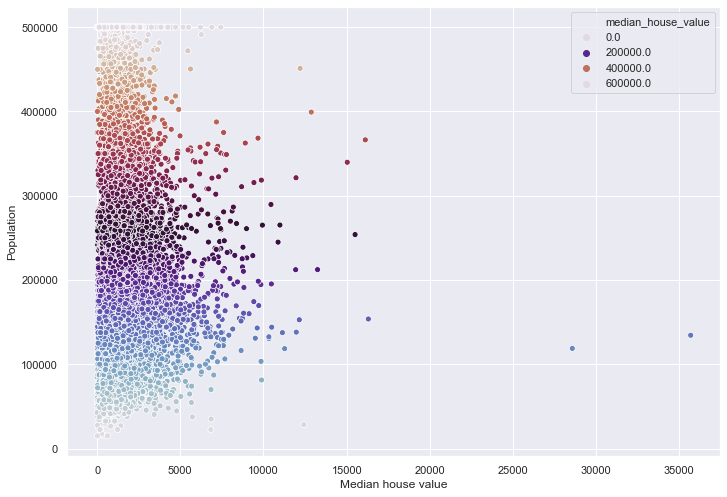

In [8]:
scatterplot_tenants = sns.scatterplot(train_set['population'], train_set['median_house_value'], hue=train_set['median_house_value'], palette='twilight')
scatterplot_tenants.set(xlabel='Median house value', ylabel='Population');

The dataset is skewed towards the left size so it provides more information about cheaper houses rather the most expensive ones.

Nevertheless, it can be seen that there is a tendency that the cheaper the house block is, the more people lives there.

### Location

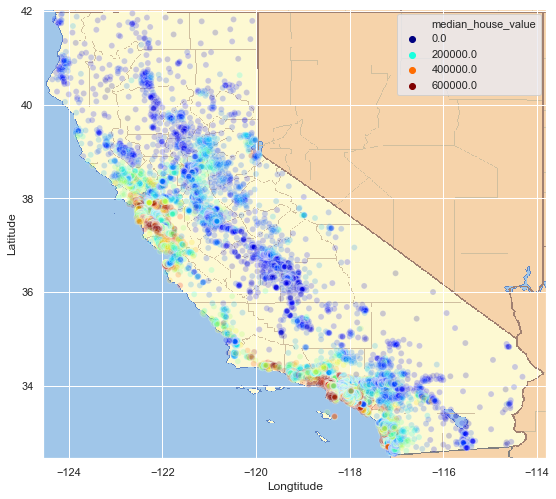

In [9]:
import matplotlib.image as mpimg


scatterplot_map = sns.scatterplot(train_set['longitude'], train_set['latitude'], alpha=.2, hue=train_set['median_house_value'], palette='jet')
datafile = mpimg.imread('images/california.png')
plt.imshow(datafile, zorder=0, extent=[-124.55, -113.80, 32.45, 42.05])
scatterplot_map.set(xlabel='Longtitude', ylabel='Latitude');

The most expensive area is San Hose and San Francisco with house prices reaching above 600,000 USD. The second most expensive area is Los Angeles. The rest of the country is much cheaper with prices ranges from 100,000 to 300,000 USD.

### Location area

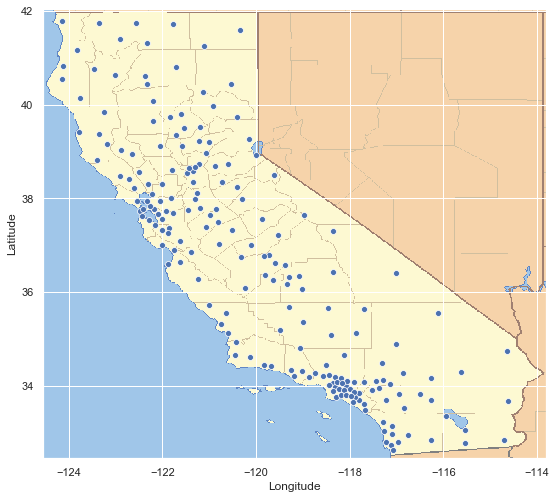

In [10]:
from sklearn.cluster import KMeans
import matplotlib.image as mpimg


coords = train_set[['longitude', 'latitude']]
kmeans = KMeans(n_clusters=200, random_state=0).fit(coords)
centres = kmeans.cluster_centers_

scatterplot_map = sns.scatterplot(centres[:, 0], centres[:, 1])
datafile = mpimg.imread('images/california.png')
plt.imshow(datafile, zorder=0, extent=[-124.55, -113.80, 32.45, 42.05])
scatterplot_map.set(xlabel='Longitude', ylabel='Latitude');

In [11]:
coords_size = len(set(zip(train_set['longitude'], train_set['latitude'])))
print(f"Number of unique locations: {coords_size}")

Number of unique locations: 12590


Removing longitude and latitude and replacing it with label might have positive impact on the performance of the ML model. It should also prevent overfitting. Although the label produced by KMeans algorithm is numeric it has to be treated as a discrete (categorical) value.

Eventually, 12590 values could be replaced to number of selected clusters.

### Biggest cities

In [12]:
from california_housing_prices.load_data import load_data
import matplotlib.image as mpimg


cities = load_data('./dataset/', 'california_cities.csv')
cities.head(3)

,name,population,longitude,latitude
0,Los Angeles,3884307,-118.24,34.05
1,San Diego,1355896,-117.16,32.71
2,San Jose,998537,-121.88,37.33


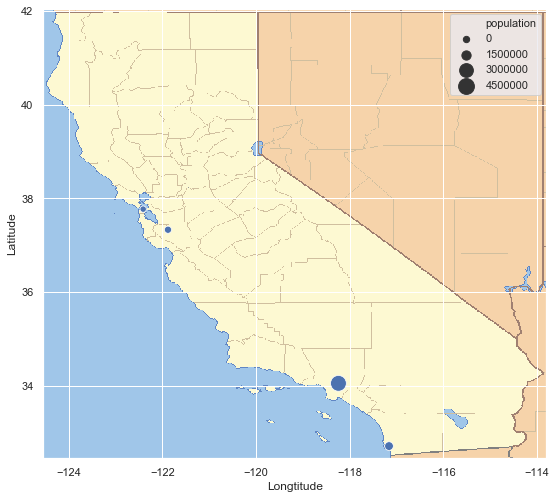

In [13]:
scatterplot_cities_map = sns.scatterplot(cities['longitude'], cities['latitude'], size=cities['population'], sizes=(40, 250))
datafile = mpimg.imread('images/california.png')
plt.imshow(datafile, zorder=0, extent=[-124.55, -113.80, 32.45, 42.05])
scatterplot_cities_map.set(xlabel='Longtitude', ylabel='Latitude');

As part of feature engineering process, a new CSV file has been created that contains data about the biggest cities in the state of California.

It can be then used to add a new feature to a training set called 'dist_to_city'. The hypothesis is that the closer the household is to the city, the more expensive it is.

In addition, another feature can be added called 'nearby_city_population' that would contain the population of the biggest, nearby city.

### Features correlation

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64


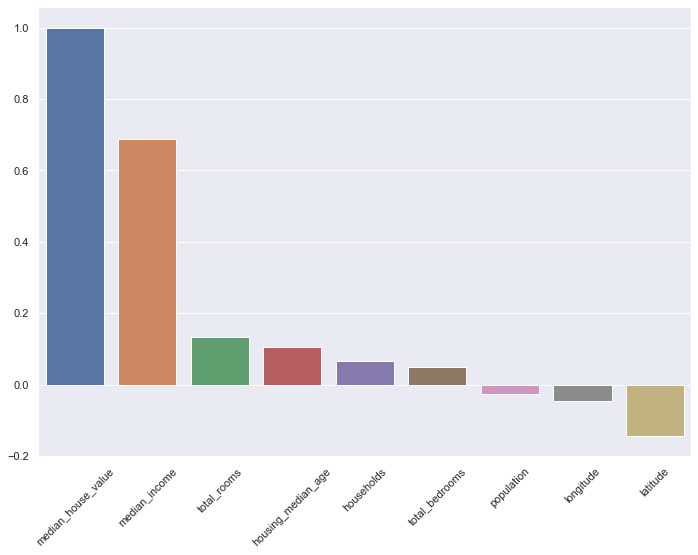

In [14]:
median_house_value_corr = train_set.corr()['median_house_value'].sort_values(ascending=False)
chart_corr = sns.barplot(median_house_value_corr.index, median_house_value_corr.values)
chart_corr.set_xticklabels(chart_corr.get_xticklabels(), rotation=45)
print(median_house_value_corr);

The most important factor for a median house value is median income of the housing area with ~68.8% correlation. The next most important factor is total number of rooms which has significantly less impact - just ~13.4%.

Interestingly, features like population or latitude seems not to have linear correlation at all.

## Preparing data

### Analysis

As a first step, it is needed to check for empty/null values across the whole dataset.

In [15]:
train_set.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

### Outliers removal

In [16]:
from scipy import stats


z = np.abs(stats.zscore(train_set['median_house_value']))
train_set_no_outliers = train_set.drop(*np.where(z > 1.7))
train_set_no_outliers = train_set_no_outliers[train_set_no_outliers['ocean_proximity'] != 'NEAR BAY']

### Preparation

In [17]:
from sklearn.model_selection import train_test_split


train_label = train_set_no_outliers['median_house_value']
X_train, X_test, Y_train, Y_test = train_test_split(train_set_no_outliers, train_label, test_size=0.2, random_state=42)
print(f'''
Size of train set: {np.shape(X_train)}
Size of test set: {np.shape(X_test)}
Size of train label vector: {np.shape(Y_train)}
Size of test label vector: {np.shape(Y_test)}
''')


Size of train set: (13587, 10)
Size of test set: (3397, 10)
Size of train label vector: (13587,)
Size of test label vector: (3397,)



### Transformation

As part of the preparation phase, there are number of steps involved:

* Populate null/missing values in total_bedrooms column
* Convert ocean_proximity feature to one hot values
* Add new features:
    * household density - proportion of households to population.
    * bedroom density - proportion of bedrooms to rooms
    * room density - proportion of rooms to households
    * population - income ratio
    * distance (in kilometers) to one of the four biggest cities
* Replace current longitude and latitude with new property that will describe area
* Scale the numeric features

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from california_housing_prices.household_density import HouseholdDensity
from california_housing_prices.room_density import RoomDensity
from california_housing_prices.bedroom_density import BedroomDensity
from california_housing_prices.population_value import PopulationValue
from california_housing_prices.location_cluster import LocationCluster
from california_housing_prices.city_distance import CityDistance


cat_columns = ['ocean_proximity']
num_columns = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']

num_pipeline = Pipeline([
    ('household_density', HouseholdDensity()),
    ('room_density', RoomDensity()),
    ('bedroom_density', BedroomDensity()),
    ('city_distance', CityDistance(cities)),
    ('population_value', PopulationValue()),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('vectorizer', OneHotEncoder())
])

col_pipeline = ColumnTransformer(
    transformers = [
        ('num', num_pipeline, num_columns),
        ('cat', cat_pipeline, cat_columns)
    ])

prep_pipeline = Pipeline([
    ('location_cluster', LocationCluster()),
    ('preprocessor', col_pipeline)
])

## Transforming data

In [19]:
train_set_unlabelled = X_train.drop(columns='median_house_value')
test_set_unlabelled = X_test.drop(columns='median_house_value')

prep_train_set = prep_pipeline.fit_transform(train_set_unlabelled, train_set['median_house_value'])
print(f'Size of prepared train set: {np.shape(prep_train_set)}')
prep_test_set = prep_pipeline.transform(test_set_unlabelled)
print(f'Size of prepared train set: {np.shape(prep_test_set)}')

Size of prepared train set: (13587, 17)
Size of prepared train set: (3397, 17)


## Model comparison

In [28]:
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from pandas import DataFrame


classifiers = {
    'SVR': SVR(),
    'Linear Regression': LinearRegression(),
    'Lasso': Lasso(max_iter=10000),
    'Elastic Net': ElasticNet(),
    'Decision Tree Regressor': DecisionTreeRegressor(),
    'Random Forest Regressor': RandomForestRegressor(),
    'XGBoost Regressor': XGBRegressor(objective ='reg:squarederror')
}

columns = ['Classifier', 'RMSE', 'R2']
df_scores = DataFrame(columns=columns)

for name, clf in classifiers.items():
    clf.fit(prep_train_set, Y_train)
    Y_predicted = clf.predict(prep_test_set)
    rmse = np.sqrt(mean_squared_error(Y_test, Y_predicted))
    r2 = r2_score(Y_test, Y_predicted)
    df_row = DataFrame([[name, rmse, r2]], columns=columns)
    df_scores = df_scores.append(df_row, ignore_index=True)

df_scores.sort_values(by='R2', ascending=False)

C:\Users\User\.virtualenvs\ml-dataset-analysis-eKEAK5HG\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


,Classifier,RMSE,R2
5,Random Forest Regressor,40900.478483,0.767736
6,XGBoost Regressor,42641.829060,0.747537
2,Lasso,50079.379188,0.651788
1,Linear Regression,50080.189853,0.651777
3,Elastic Net,57185.559010,0.545956
4,Decision Tree Regressor,57416.797896,0.542276
0,SVR,85511.482650,-0.015253


## Hyper-parameter tuning

In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error


rf_clf = RandomForestRegressor(criterion='mse')
param_grid = {
    'max_features': ['auto'],
    'oob_score': [False, True],
    'ccp_alpha': [0, .001],
    'min_weight_fraction_leaf': [0, .001],
    'min_impurity_decrease': [0, .001]
}

grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=4, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(prep_train_set, Y_train)

best_rf_clf = grid_search.best_estimator_
best_rf_params = grid_search.best_params_
Y_predicted = best_rf_clf.predict(prep_test_set)
print(f"RMSE: {np.sqrt(mean_squared_error(Y_test, Y_predicted))}")

RMSE: 40669.18150468512
